In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
train_subset, val_subset = torch.utils.data.random_split(trainset, [40000, 10000], generator=torch.Generator().manual_seed(1))
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)


classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
def load(batch_size) :
  trainloader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
  valloader = torch.utils.data.DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)
  return trainloader, valloader, testloader

In [5]:
def train(criterion,optimizer,trainloader,valloader,model,epochs):
  

  train_losses = []
  val_losses = []
  train_acc = []
  val_acc  = []

  for i in range(epochs):
    
      trn_corr = 0
      val_corr = 0
      batch_corr = 0
      val_batch_corr = 0
      loss_sum_train =0
      loss_sum_val =0
      

      for b_iter,data in enumerate(trainloader):
        b_iter +=1
        inputs , labels = data
        labels = labels.to(device)
        inputs = inputs.to(device)
        outputs = model(inputs)
        loss = criterion(outputs,labels)

        predicted = torch.max(outputs.data, 1)[1]
        batch_corr = (predicted == labels).sum()
        trn_corr += batch_corr.item()
        loss_sum_train += loss.item()
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
      accuracy_train = trn_corr *100 / (len(trainloader.dataset))
      train_losses.append(loss_sum_train/b_iter)
      train_acc.append(accuracy_train)




      with torch.no_grad():
        b_iter = 0
        for b_iter,data in enumerate(valloader):
          b_iter +=1
          inputs , label = data
          label = label.to(device)
          input = inputs.to(device)
          y_val = model(input)

          predicted = torch.max(y_val.data, 1)[1]
          val_batch_corr = (predicted == label).sum()
          val_corr += val_batch_corr.item()
          loss_v = criterion(y_val,label.to(device))
          loss_sum_val += loss_v.item()
          
        accuracy_v = val_corr*100 / (len(valloader.dataset))
        val_losses.append(loss_sum_val/b_iter)
        val_acc.append(accuracy_v)

      print('epoch :',i ,', loss_train :',loss_sum_train/b_iter,', accuracy_train :',accuracy_train,', loss_val : ',loss_sum_val/b_iter,', accuracy_v :',accuracy_v)




      #print('epoch: {} , loss_train: {} , accuracy_train: {} '.format(i,loss_sum_train/b_iter,accuracy_train)
      

  return train_losses, train_acc, val_losses, val_acc

In [6]:
def load_optimize_train(model,loss_function,optimizerr,epochs,batch_size):
  
  trainloader, valloader, testloader = load(batch_size)
  criterion = loss_function
  optimizer = optimizerr
  train_losses, train_acc, val_losses, val_acc = train(criterion,optimizer,trainloader,valloader,model,epochs)
  return testloader,criterion,train_losses, train_acc, val_losses, val_acc

In [7]:
def plot(x, y, x_label, y_label, t):
  plt.plot(x,label=x_label)
  plt.plot(y,label=y_label)
  plt.legend()
  plt.xlabel("epoch")
  plt.ylabel(t)
  #plt.title(t)
  plt.show()


In [8]:
from sklearn.metrics import recall_score, accuracy_score ,precision_score,f1_score,confusion_matrix
def test(testloader,criterion,model):

  with torch.no_grad():
    test_corr = 0
    b_iter = 0
    loss_sum_test = 0
    orginal_labels = []
    predicted_labels = []

    for b_iter,data in enumerate(testloader):
      b_iter +=1
      inputs , labels = data
      labels = labels.to(device)
      orginal_labels.extend(labels.tolist())
      inputs = inputs.to(device)
      y_test = model(inputs).to(device)
      predicted = torch.max(y_test.data, 1)[1]
      predicted_labels.extend(predicted.tolist())
      loss_test= criterion(y_test,labels)
      loss_sum_test += loss_test.item()
      
  accuracy_test = accuracy_score(orginal_labels, predicted_labels)*100
  recall = recall_score(orginal_labels, predicted_labels,average='micro')*100
  precision = precision_score(orginal_labels, predicted_labels,average='macro')*100
  f1_s = f1_score(orginal_labels, predicted_labels,average='weighted')*100
  confusion_m = confusion_matrix(orginal_labels, predicted_labels)
  print('"Test"')
  print('accuracy: {},recall : {} ,precision : {}, f1_score : {}, loss_test : {},\n confusion_matrix :\n {}  '
  .format(accuracy_test, recall, precision, f1_s,loss_sum_test/b_iter,confusion_m))

In [9]:
def epochs_plots_test (epochs,batch_size,loss_function,optimize, model ):
  testloader,criterion,train_losses, train_acc, val_losses, val_acc = load_optimize_train(model,loss_function,optimizer,epochs,batch_size)
  plot(train_losses,val_losses,"train", 'validation','loss' )
  plot(train_acc,val_acc,"train", 'validation','accuracy' )
  test(testloader,criterion,model)


# الف

In [10]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*24*24, 128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = F.relu(self.conv1(x)) 
        x = F.relu(self.conv2(x)) 
        x = x.view(-1, 16*24*24)            
        x = F.relu(self.fc1(x))               
        x = F.relu(self.fc2(x))
        x = self.fc3(x)                
                             
        return x


epoch : 0 , loss_train : 7.711350578296034 , accuracy_train : 29.8525 , loss_val :  1.7411734816394275 , accuracy_v : 36.85
epoch : 1 , loss_train : 6.565963319585293 , accuracy_train : 40.43 , loss_val :  1.610283370259442 , accuracy_v : 41.48
epoch : 2 , loss_train : 6.178401824794238 , accuracy_train : 44.3925 , loss_val :  1.5461334533329252 , accuracy_v : 43.94
epoch : 3 , loss_train : 5.974940983554985 , accuracy_train : 46.385 , loss_val :  1.5096789628644534 , accuracy_v : 45.41
epoch : 4 , loss_train : 5.821232809296137 , accuracy_train : 47.63 , loss_val :  1.4890629626527618 , accuracy_v : 46.01
epoch : 5 , loss_train : 5.705263247972803 , accuracy_train : 48.5675 , loss_val :  1.4655440864683706 , accuracy_v : 47.03
epoch : 6 , loss_train : 5.577871129482607 , accuracy_train : 49.9 , loss_val :  1.4365120869648607 , accuracy_v : 48.33
epoch : 7 , loss_train : 5.46794342089303 , accuracy_train : 50.925 , loss_val :  1.4312334015399595 , accuracy_v : 48.48
epoch : 8 , loss_tr

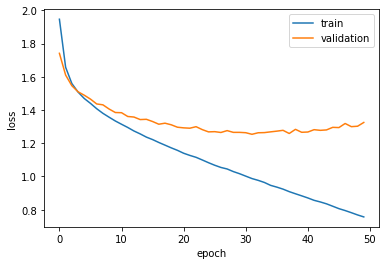

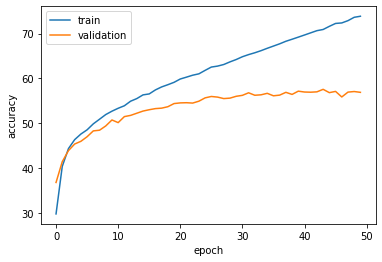

"Test"
accuracy: 57.269999999999996,recall : 57.269999999999996 ,precision : 57.23983242836581, f1_score : 56.98628324384365, loss_test : 1.3062067265751995,
 confusion_matrix :
 [[710  34  52  29  15  11  13  10  69  57]
 [ 44 736   6  13   2   7   8   7  29 148]
 [ 80  20 453  97  85 105  78  42  21  19]
 [ 44  18  80 394  50 202  88  60  22  42]
 [ 54   8 146  88 370  89  89 121  18  17]
 [ 25   8  77 179  35 489  42 111  12  22]
 [ 16  26  68  99  59  43 637  20   9  23]
 [ 24  10  35  60  51  98  10 651   6  55]
 [142  73  24  17  15  10   4  12 658  45]
 [ 58 157  15  18   9  17  14  48  35 629]]  


In [13]:
epochs = 50
batch_size =128
model = ConvNet()
model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs_plots_test (epochs,batch_size,loss_function,optimizer, model)

# ب

In [14]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1=nn.BatchNorm2d(num_features=6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2=nn.BatchNorm2d(num_features=16)
        self.fc1 = nn.Linear(16*5*5, 128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.bn1(self.pool(F.relu(self.conv1(x))))  
        x = self.bn2(self.pool(F.relu(self.conv2(x)))) 
        x = x.view(-1, 16*5*5)            
        x = F.relu(self.fc1(x))               
        x = F.relu(self.fc2(x))
        x = self.fc3(x)                
                             
        return x


epoch : 0 , loss_train : 7.6433367321762855 , accuracy_train : 30.69 , loss_val :  1.6672367053695871 , accuracy_v : 39.5
epoch : 1 , loss_train : 6.1512775179706045 , accuracy_train : 43.4825 , loss_val :  1.4666512087930608 , accuracy_v : 46.55
epoch : 2 , loss_train : 5.571217290962799 , accuracy_train : 48.8725 , loss_val :  1.3833328817464128 , accuracy_v : 49.82
epoch : 3 , loss_train : 5.262698063367529 , accuracy_train : 51.9725 , loss_val :  1.333171010017395 , accuracy_v : 51.75
epoch : 4 , loss_train : 5.0293741256375855 , accuracy_train : 54.2 , loss_val :  1.289049095745328 , accuracy_v : 53.51
epoch : 5 , loss_train : 4.851376621029045 , accuracy_train : 55.8075 , loss_val :  1.2618790080275717 , accuracy_v : 54.59
epoch : 6 , loss_train : 4.6925291041784645 , accuracy_train : 57.28 , loss_val :  1.2423473838009411 , accuracy_v : 55.63
epoch : 7 , loss_train : 4.568888018402872 , accuracy_train : 58.565 , loss_val :  1.214046364343619 , accuracy_v : 56.46
epoch : 8 , loss

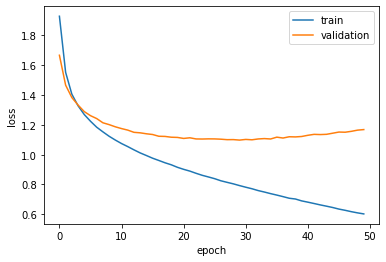

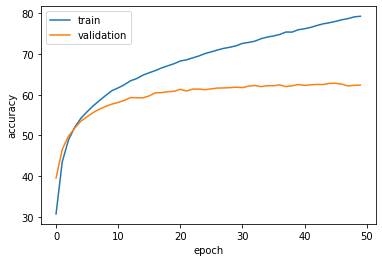

"Test"
accuracy: 62.92,recall : 62.92 ,precision : 62.68213588111769, f1_score : 62.73860453488983, loss_test : 1.1568965496896189,
 confusion_matrix :
 [[697  30  48  19  28  14  16  12  96  40]
 [ 28 742  12  11   6   7  15   6  52 121]
 [ 69  12 452  91 141  74  74  44  27  16]
 [ 30  15  75 427  78 195  80  44  21  35]
 [ 24   5  79  68 604  41  69  85  17   8]
 [ 16   4  67 160  53 553  41  81  11  14]
 [  4  11  42  84  63  38 714  15  12  17]
 [ 19  10  31  57  77  78  11 678   5  34]
 [ 96  51  12  22  11   6  12   6 751  33]
 [ 54 130  11  21  10  10  22  23  45 674]]  


In [15]:
epochs = 50
batch_size =128
model = ConvNet()
model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs_plots_test (epochs,batch_size,loss_function,optimizer, model)

# ج

In [11]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1=nn.BatchNorm2d(num_features=6)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2=nn.BatchNorm2d(num_features=16)
        self.fc1 = nn.Linear(16*5*5, 128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.drop1(self.bn1(self.pool(F.relu(self.conv1(x)))))
        x = self.drop1(self.bn2(self.pool(F.relu(self.conv2(x)))))
        x = x.view(-1, 16*5*5)            
        x = self.drop1(F.relu(self.fc1(x)))              
        x = self.drop1(F.relu(self.fc2(x))) 
        x = self.drop1(self.fc3(x))          
                             
        return x


epoch : 0 , loss_train : 8.368239268471923 , accuracy_train : 23.0325 , loss_val :  1.9440434431727929 , accuracy_v : 27.77
epoch : 1 , loss_train : 7.405120932603184 , accuracy_train : 31.8975 , loss_val :  1.8086900514892386 , accuracy_v : 33.52
epoch : 2 , loss_train : 7.003221950953519 , accuracy_train : 35.775 , loss_val :  1.7396399959733215 , accuracy_v : 36.8
epoch : 3 , loss_train : 6.781386849246448 , accuracy_train : 37.835 , loss_val :  1.690259095988696 , accuracy_v : 38.76
epoch : 4 , loss_train : 6.598227238353295 , accuracy_train : 39.8375 , loss_val :  1.6491420419910285 , accuracy_v : 39.92
epoch : 5 , loss_train : 6.470517072496535 , accuracy_train : 40.9575 , loss_val :  1.6342696705950965 , accuracy_v : 40.51
epoch : 6 , loss_train : 6.35487139375904 , accuracy_train : 42.1925 , loss_val :  1.6105849833428105 , accuracy_v : 41.91
epoch : 7 , loss_train : 6.249336452423772 , accuracy_train : 42.9025 , loss_val :  1.5838765237904802 , accuracy_v : 42.97
epoch : 8 , l

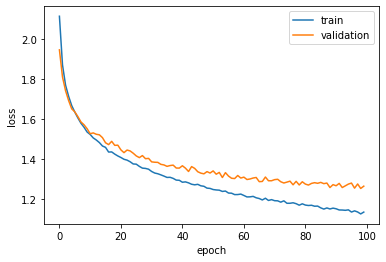

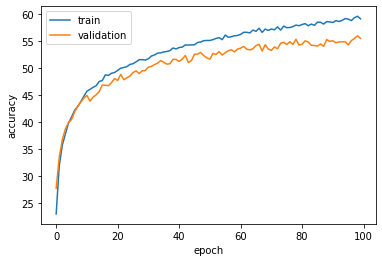

"Test"
accuracy: 55.05,recall : 55.05 ,precision : 55.22176117628107, f1_score : 55.05050869397776, loss_test : 1.2867299740827536,
 confusion_matrix :
 [[638  35  59  43  25  10  10  15 110  55]
 [ 65 720   6  11  10   7  17  10  36 118]
 [ 70  16 433  97 117  88  78  53  30  18]
 [ 34  22  83 388  89 191  80  55  21  37]
 [ 26  16 137  74 483  49  96  87  21  11]
 [ 18  18 100 222  50 454  38  72  15  13]
 [ 36  32  84 103  66  34 605  23  11   6]
 [ 27  29  59  63  93  74  22 588   8  37]
 [140  73  40  35  14  11  10   6 623  48]
 [ 62 175  18  35  18  14  23  31  51 573]]  


In [12]:
epochs = 100 # dr = 0.2 in conv layer
batch_size =128
model = ConvNet()
model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs_plots_test (epochs,batch_size,loss_function,optimizer, model)

# د

In [18]:
def train(criterion,optimizer,trainloader,valloader,model,epochs):
  
  # Early stopping
  the_last_loss = 100
  patience = 2
  trigger_times = 0
  train_losses = []
  val_losses = []
  train_acc = []
  val_acc  = []

  for i in range(epochs):
    
      trn_corr = 0
      val_corr = 0
      batch_corr = 0
      val_batch_corr = 0
      loss_sum_train =0
      loss_sum_val =0
      

      for b_iter,data in enumerate(trainloader):
        b_iter +=1
        inputs , labels = data
        labels = labels.to(device)
        inputs = inputs.to(device)
        outputs = model(inputs)
        loss = criterion(outputs,labels)

        predicted = torch.max(outputs.data, 1)[1]
        batch_corr = (predicted == labels).sum()
        trn_corr += batch_corr.item()
        loss_sum_train += loss.item()
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
      accuracy_train = trn_corr *100 / (len(trainloader.dataset))
      train_losses.append(loss_sum_train/b_iter)
      train_acc.append(accuracy_train)
      



      with torch.no_grad():
        b_iter = 0
        for b_iter,data in enumerate(valloader):
          b_iter +=1
          inputs , label = data
          label = label.to(device)
          input = inputs.to(device)
          y_val = model(input)

          predicted = torch.max(y_val.data, 1)[1]
          val_batch_corr = (predicted == label).sum()
          val_corr += val_batch_corr.item()
          loss_v = criterion(y_val,label.to(device))
          loss_sum_val += loss_v.item()
          
        accuracy_v = val_corr*100 / (len(valloader.dataset))
        val_losses.append(loss_sum_val/b_iter)
        val_acc.append(accuracy_v)

      print('epoch :',i ,', loss_train :',loss_sum_train/b_iter,', accuracy_train :',accuracy_train,', loss_val',loss_sum_val/b_iter,', accuracy_v :',accuracy_v)

      the_current_loss = loss_sum_val/b_iter
      # Early stopping
      print('The current loss:', the_current_loss)

      if the_current_loss > the_last_loss:
        trigger_times += 1
        print('trigger times:', trigger_times)

        if trigger_times >= patience:
          print('Early stopping!\nStart to test process.')
          return train_losses, train_acc, val_losses, val_acc

      else:
          print('trigger times: 0')
          trigger_times = 0

      the_last_loss = the_current_loss

      #print('epoch: {} , loss_train: {} , accuracy_train: {} '.format(i,loss_sum_train/b_iter,accuracy_train)
      

  return train_losses, train_acc, val_losses, val_acc

epoch : 0 , loss_train : 8.033666118790832 , accuracy_train : 24.9475 , loss_val 1.7970241368571414 , accuracy_v : 32.4
The current loss: 1.7970241368571414
trigger times: 0
epoch : 1 , loss_train : 6.787772776205329 , accuracy_train : 36.5275 , loss_val 1.6369444478916217 , accuracy_v : 38.99
The current loss: 1.6369444478916217
trigger times: 0
epoch : 2 , loss_train : 6.329237301138383 , accuracy_train : 40.7625 , loss_val 1.5616085725494577 , accuracy_v : 42.15
The current loss: 1.5616085725494577
trigger times: 0
epoch : 3 , loss_train : 6.054638992382001 , accuracy_train : 43.81 , loss_val 1.5099828786487821 , accuracy_v : 44.15
The current loss: 1.5099828786487821
trigger times: 0
epoch : 4 , loss_train : 5.864131213743476 , accuracy_train : 46.05 , loss_val 1.478660450705999 , accuracy_v : 45.77
The current loss: 1.478660450705999
trigger times: 0
epoch : 5 , loss_train : 5.727888816519629 , accuracy_train : 47.655 , loss_val 1.440119912352743 , accuracy_v : 47.86
The current l

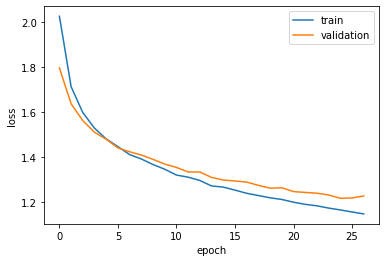

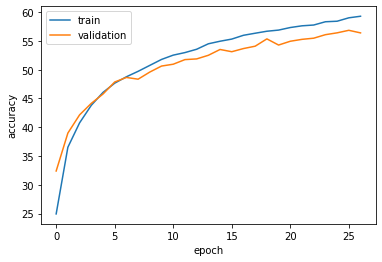

"Test"
accuracy: 56.66,recall : 56.66 ,precision : 56.238557573400904, f1_score : 56.394780970878635, loss_test : 1.2124158061003383,
 confusion_matrix :
 [[612  47  77  16  21  10  11  17 147  42]
 [ 40 692   9  11  15   4  19  16  64 130]
 [ 98  15 445  72 114 101  71  53  18  13]
 [ 32  26  76 358  86 193 108  65  24  32]
 [ 35  13 121  71 459  46 107 122  16  10]
 [ 18  11 110 169  55 468  52  91  17   9]
 [  8  12  70  81  74  32 665  26   7  25]
 [ 19  11  43  59  76  94  25 645   5  23]
 [142  56  20  18  14   6  11   6 674  53]
 [ 46 134   9  19  13   3  25  25  78 648]]  


In [20]:
epochs = 100 # dr = 0.2
batch_size =128
model = ConvNet()
model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs_plots_test (epochs,batch_size,loss_function,optimizer, model)